# The Transportation Problem

**Key Ideas**
- supply point and supply constraint
- demand point and demand constraint
- balanced transportation problem
- bipartite graph
- integrality properties
- sensitivity analysis

**Reading Assignment**
- Read the first part of Handout 7 on the transportation problem (first 4 pages)

**Brief description:** We will explore examples of the transportation problem including some unexpected ones. We will also learn how to use Python and OR-Tools to represent and solve mathematical programming problems.

### Import the following

In [1]:
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from ortools.linear_solver import pywraplp as OR
from IPython.display import Image

### Part 1: The Caterer's Problem

(From Winston, page 390) The Carter Caterer Company must have the following number of clean napkins available
at the beginning of each of the next four days: day 1, 15; day 2, 12; day 3, 18; day 4, 6. After being used, a napkin
can be cleaned by one of two methods: fast service or slow service. Fast service costs 10 cents per napkin, and
a napkin cleaned via fast service is available for use the day after it is last used. Slow service costs 6 cents per
napkin, and these napkins can be reused two days after they are last used. New napkins can be purchased for a
cost of 20 cents per napkin. The catering company currently has no napkins, whatsoever. We wish to meet the
demand for the next four days as cheaply as possible.

The following questions will lead you to formulate this optimization problem as a balanced transportation problem.

**Q1:** First think about the demand points. What do you think is being demanded? What is the demand for each of them? <font color='grey'>(Hint: There are four demand points.) </font>

*Answer:* <font color='blue'> There are four demand points; 1 for each of the next four days. They have demand 15,12,18, and 6 respectivley.</font>

**Q2:** Now think about the supply points. One supply point is the store where napkins are purchased. What are all the supply points? What is the supply for each of them? <font color='grey'>(Hint: Napkins used on day $i$ can come from those used on day $i-1$ given fast service or day $i-2$ given slow service.) </font>

*Answer:* <font color='blue'> The other supply points are the ends of the first three days. Their supplies are 15, 12, and 18 respectively. The supply of the first supply node is infinity.</font>  

**Q3:** What is the per-unit shipping cost between each supply point and each demand point?

*Answer:* <font color='blue'> The per-unit shipping cost between the store supply node and every demand node is 20. The per-unit shipping cost between the supply node representing the supply at the end of the day $i$ and day $i+1$ is 10 and 6 for day $i+2$. </font>

**Q4:** Create a graphical representation of this input (combine your answers from Q1-Q3), and upload as an image into the next cell by entering the image name if it is in the same folder as this lab. Make sure that it displays properly within the notebook.

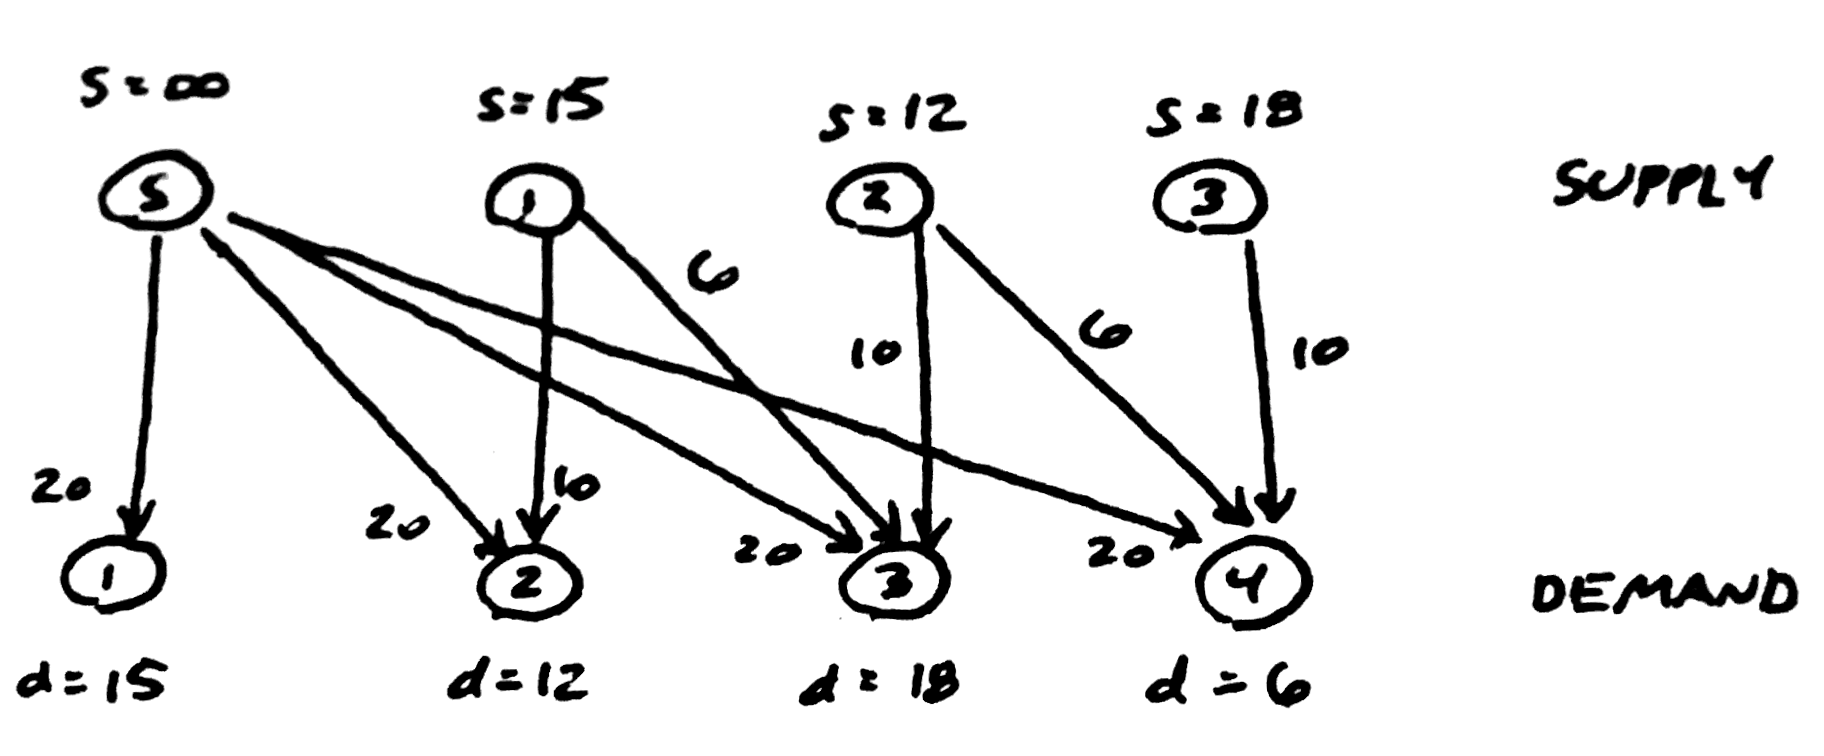

In [2]:
Image('q4_graph.png')

We came up with the following formulation for the Caterer’s Problem where the demand points are the four days (1, 2, 3, 4) and the supply points are the store ($s$) and the ends of the first three days (1’, 2’, 3’). The supply/demand amounts and costs are summarized in the table below. Did you get a similar formulation?

|         | 1  | 2  | 3  | 4  | supplies |
|---------|----|----|----|----|----------|
| $s$     | 20 | 20 | 20 | 20 | $\infty$ |
| 1'      | -  | 10 | 6  | -  | 15       |
| 2'      | -  | -  | 10 | 6  | 12       |
| 3'      | -  | -  | -  | 10 | 18       |
| demands | 15 | 12 | 18 | 6  |          |

**Q5:** Since we do not usually deal with infinity, what is a large enough value that can be the amount of supply at $s$? <font color='grey'>(Hint: Buy new napkins every day.)</font>

*Answer:* <font color='blue'> If we buy new napkins every day then we need $15+12+18+6 = 51$ napkins from the store.</font>

**Q6:** Is this formulation balanced? If not, how can you convert it into a balanced transportation problem?

*Answer:* <font color='blue'> This formulation is not balanced because the total supply is 96 while the total demand is only 51. We can add a dummy demand node to make the formulation balanced. </font>

**Q7:** What is the purpose of a dummy demand point in terms of napkins? For instance, what napkins come here, and what happens to them?

*Answer:* <font color='blue'> Napkins that come to the dummy demand node are just thown away. They are neither laundered nor used. We assume it costs nothing to dispose of the napkins. </font>

**Q8:** Fill out the missing values (XXX) in the table below. We substituted the dashes with a big enough number like 1000.

|         | 1    | 2    | 3    | 4    | dummy | supplies |
|---------|------|------|------|------|-------|----------|
| $s$     | 20   | 20   | 20   | 20   | 0   | 51      |
| 1'      | 1000 | 10   | 6    | 1000 | 0   | 15       |
| 2'      | 1000 | 1000 | 10   | 6    | 0   | 12       |
| 3'      | 1000 | 1000 | 1000 | 10   | 0   | 18       |
| demands | 15   | 12   | 18   | 6    | 45   |          |

### Part 2: Solving Using a Computer

The next cell contains our model. In later labs, you will practice writing your own models, but for now, read through the code and run it.
- 'supply' is a dictionary of the form *origin node : supply at node*
- 'demand' is a dictionary of the form *destination node : demand at node*
- 'cost' is a dictionary of the form *(origin node, destination node) : cost to ship on this path*

In [12]:
# a transportation model
def Transp(supply, demand, cost, solver):
    ORIG = list(supply.keys())    # origins
    DEST = list(demand.keys())    # destinations
    ARCS = list(cost.keys())      # arcs
    
    # define model
    m = OR.Solver('transportation', solver)
    
    # parameters
    for i in ORIG:
        m.Add(supply[i] >= 0)
    for i in DEST:
        m.Add(demand[i] >= 0)
    for i,j in ARCS:
        m.Add(cost[i,j] >= 0)
    m.Add(sum(supply[i] for i in ORIG) == sum(demand[j] for j in DEST))
    
    # decision variables
    Trans = {}    # units to be shipped
    for i,j in ARCS:
        # Changed for question 17
        Trans[i,j] = m.IntVar(0, m.infinity(), ('(%s, %s)' % (i,j))) 
        #Trans[i,j] = m.NumVar(0, m.infinity(), ('(%s, %s)' % (i,j)))
        
    # objective function
    m.Minimize(sum(cost[i,j]*Trans[i,j] for i,j in ARCS))
        
    # subject to: equals supply
    for i in ORIG:
        m.Add(sum(Trans[i,j] for j in DEST) == supply[i])
        
    # subject to: equals demand
    for j in DEST:
        m.Add(sum(Trans[i,j] for i in ORIG) == demand[j])
        
    # Added for Q15
    m.Add(Trans['S2','R5'] <= Trans['S1','R5'] + Trans['S3','R5'] + 1)
    
    m.Solve()
    
    print('Solution:')
    print('Objective value =', m.Objective().Value())
    for i,j in ARCS:
        print(Trans[i,j].name(), ':', Trans[i,j].solution_value())

Here is an example set of data you can solve using the model.

| Steel Mills | Tons Supplied |
|-------------|---------------|
| GARY        | 1400          |
| CLEV        | 2600          |
| PITT        | 2900          |

The steel is sold to car manufacturers.

| Car Manufacturers | Tons Demanded |
|-------------------|---------------|
| FRA               | 900           |
| DET               | 1200          |
| LAN               | 600           |
| WIN               | 400           |
| STL               | 1700          |
| FRE               | 1100          |
| LAF               | 1000          |

This table contains shipping costs per ton:

|     | GARY | CLEV | PITT |
|-----|------|------|------|
| FRA | 39   | 27   | 24   |
| DET | 14   | 9    | 14   |
| LAN | 11   | 12   | 17   |
| WIN | 14   | 9    | 13   |
| STL | 16   | 26   | 28   |
| FRE | 82   | 95   | 99   |
| LAF | 8    | 17   | 20   |

In [4]:
# run me!
ex_supply = {'GARY':1400, 'CLEV':2600, 'PITT':2900}
ex_demand = {'FRA':900, 'DET':1200, 'LAN':600, 'WIN':400, 'STL':1700, 'FRE':1100, 'LAF':1000}
ex_cost = {('GARY','FRA'):39, ('CLEV','FRA'):27, ('PITT','FRA'):24,
           ('GARY','DET'):14, ('CLEV','DET'):9, ('PITT','DET'):14,
           ('GARY','LAN'):11, ('CLEV','LAN'):12, ('PITT','LAN'):17,
           ('GARY','WIN'):14, ('CLEV','WIN'):9, ('PITT','WIN'):13,
           ('GARY','STL'):16, ('CLEV','STL'):26, ('PITT','STL'):28,
           ('GARY','FRE'):82, ('CLEV','FRE'):95, ('PITT','FRE'):99,
           ('GARY','LAF'):8, ('CLEV','LAF'):17, ('PITT','LAF'):20}

Transp(ex_supply,ex_demand,ex_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 196200.0
(GARY, FRA) : 0.0
(CLEV, FRA) : 0.0
(PITT, FRA) : 900.0
(GARY, DET) : 0.0
(CLEV, DET) : 1200.0
(PITT, DET) : 0.0
(GARY, LAN) : 0.0
(CLEV, LAN) : 600.0
(PITT, LAN) : 0.0
(GARY, WIN) : 0.0
(CLEV, WIN) : 400.0
(PITT, WIN) : 0.0
(GARY, STL) : 300.0
(CLEV, STL) : 0.0
(PITT, STL) : 1400.0
(GARY, FRE) : 1100.0
(CLEV, FRE) : 0.0
(PITT, FRE) : 0.0
(GARY, LAF) : 0.0
(CLEV, LAF) : 400.0
(PITT, LAF) : 600.0


**Q9:** Complete the input for the Caterer's Problem.

In [5]:
c_supply = {'s': 51, 
            "1'": 15, 
            "2'": 12,
            "3'": 18}
c_demand = {1: 15, 
            2: 12, 
            3: 18, 
            4: 6, 
            'd':45}
c_cost = {('s',1):  20,   ('s',2):  20,   ('s',3):  20,   ('s',4):  20,   ('s','d'):  0,
          ("1'",1): 1000, ("1'",2): 10,   ("1'",3): 6,    ("1'",4): 1000, ("1'",'d'): 0,
          ("2'",1): 1000, ("2'",2): 1000, ("2'",3): 10,   ("2'",4): 6,    ("2'",'d'): 0,
          ("3'",1): 1000, ("3'",2): 1000, ("3'",3): 1000, ("3'",4): 10,   ("3'",'d'): 0}
Transp(c_supply,c_demand,c_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 666.0
(s, 1) : 15.0
(s, 2) : 3.0
(s, 3) : 0.0
(s, 4) : 0.0
(s, d) : 33.0
(1', 1) : 0.0
(1', 2) : 9.0
(1', 3) : 6.0
(1', 4) : 0.0
(1', d) : 0.0
(2', 1) : 0.0
(2', 2) : 0.0
(2', 3) : 12.0
(2', 4) : 0.0
(2', d) : 0.0
(3', 1) : 0.0
(3', 2) : 0.0
(3', 3) : 0.0
(3', 4) : 6.0
(3', d) : 12.0


**Q10:** Reinterpret the solution in words including how we get napkins for each day.

*Answer:* <font color='blue'> The first day, we just have to buy all of our napkins (15). We then get 9 cleaned using the fast service and 6 cleaned using the slow service. The 9 in addition to 3 new napkins satisfy the demand for the second day. After which, all 12 are cleaned using the fast service. These, along with 6 from day 1 satisfy the demand for the third day. Lastly, 6 napkins are cleaned using the fast system to be ready for the final day. </font>

### Part 3: Exploring the Optimal Solution

We will start by solving a new problem. An oil company imports crude from three sources and refines it at five refineries. Sources 1, 2, 3 can ship 20, 50, 20 units of crude respectively each week. Refineries 1 to 5 need 10, 24, 6, 20, 30 units of crude respectively each week. The table below contains the unit shipping costs from the sources to the refineries. The entry in the $i$th row and $j$th column gives the cost to ship from source $i$ to refinery $j$.

|    |    |    |    |    |
|----|----|----|----|----|
| 30 | 30 | 10 | 27 | 15 |
| 15 | 15 | 8  | 13 | 5  |
| 25 | 21 | 5  | 15 | 21 |

**Q11:** Solve the oil problem using our Python model. Define the input to the model like the example and run the cell.

In [6]:
o_supply = {'S1':20, 
            'S2':50, 
            'S3':20}
o_demand = {'R1':10, 
            'R2':24, 
            'R3':6, 
            'R4':20, 
            'R5':30}
o_cost = {('S1','R1'):30, ('S1','R2'):30, ('S1','R3'):10, ('S1','R4'):27, ('S1','R5'):15,
          ('S2','R1'):15, ('S2','R2'):15, ('S2','R3'):8, ('S2','R4'):13, ('S2','R5'):5,
          ('S3','R1'):25, ('S3','R2'):21, ('S3','R3'):5, ('S3','R4'):15, ('S3','R5'):21}
Transp(o_supply,o_demand,o_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 1160.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 6.0
(S1, R4) : 0.0
(S1, R5) : 14.0
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.0
(S2, R5) : 16.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.0
(S3, R4) : 20.0
(S3, R5) : 0.0


Now consider the values $u(1) = 25$, $u(2) = 15$, $u(3) = 17$, $v(1) = 0$, $v(2) = 0$, $v(3) = -15$, $v(4) = -2$, and $v(5) = -10$.  

**Q12:** Write down the modified cost matrix, where as shown in class, we subtract $u(i)$ from all the entries in row $i$, and similarly we subtract $v(j)$ from each entry of column $j$. Argue why the solution computed above is indeed optimal for the original input.

*Answer:*

|    |    |    |    |    |
|----|----|----|----|----|
| 5 | 5 | 0 | 4 | 0 |
| 0 | 0 |8  | 0 | 0  |
| 8 | 4 | 3  | 0 | 14 |

<font color='blue'> In the solution above, all non-zero $x_{ij}$ have modified cost equal to zero. Hence, the solution must be optimal. </font>

<font color='red'> This differs from the answer key that Frans made. Get a second set of eyes on this.</font>

Now suppose that we anticipate the cost of shipping from source 1 to refinery 1 (currently equal 30) to go down. Observe that in the current optimal solution, we do not ship anything from source 1 to refinery 1. An interesting question is "By how much should $c(1,1)$ decrease before we will consider shipping some positive amount along that path?"

**Q13:** Try the following values for $c(1,1)$: 28, 26, 25, 24. (Note: Use the same names from Q11 for the nodes.) Record the optimal solutions in the table. Also include the value $\overline{c}(1,1)$ from the matrix of modified costs (recall $\overline{c}(1,1) = c(1,1) - u(1) - v(1)$). What can you conclude?

In [7]:
o_cost['S1','R1'] = 24
Transp(o_supply,o_demand,o_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 1150.0
(S1, R1) : 10.0
(S1, R2) : 0.0
(S1, R3) : 6.0
(S1, R4) : 0.0
(S1, R5) : 4.0
(S2, R1) : 0.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.0
(S2, R5) : 26.000000000000004
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.0
(S3, R4) : 20.0
(S3, R5) : 0.0


*Answer:* 

|                     | 28          | 26          | 25         | 24 |
|---------------------|-------------|-------------|------------|----|
|                     | x(1,3) = 6  | same as 28  | same as 28 | x(1,1) = 10 |   
|                     | x(1,5) = 14 |             |            | x(1,3) = 6  |
|                     | x(2,1) = 10 |             |            | x(1,5) = 4   |
|                     | x(2,2) = 24 |             |            | x(2,2) = 24   |
|                     | x(2,5) = 16 |             |            | x(2,5) = 26   |
|                     | x(3,4) = 20 |             |            | x(3,4) = 20   |
| $\overline{c}$(1,1) |  3          |  1          |      0     | -1 |

<font color='blue'> Once the modified cost becomes negative, the edge will enter the solution. </font>

Now consider the original model with $c(1,1) = 30$. 

**Q14:** Could you use the modified cost matrix to answer the same kind of question raised above for changes in any $c(i,j)$ parameter? Try to use your observations to figure out by how much the value of $c(2,3)$ needs to be reduced so that we will consider shipping from source 2 to refinery 3. Check your answer using our Python model.

*Answer:* <font color='blue'> The value of $c(2,3)$ needs to be decreased by at least 8 for the edge to enter the solution. </font>

<font color='red'> This differs from the answer key that Frans made. Get a second set of eyes on this.</font>

Once again start with the original model and data. Because of a trade agreement, the amount that is shipped from source 2 to refinery 5 cannot exceed the amount that is shipped to refinery 5 from sources 1 and 3 combined by more than 1. Add a constraint like the following to the model function to represent this trade agreement: `m.Add(Trans['S2','R5'] <= Trans['S1','R5'] + Trans['S3','R5'] + 1)`. Make sure to re-run the cell defining the model to add this change.

**Q15:** Rerun the model cell and re-solve to find the new optimal solution and objective value.

In [11]:
o_supply = {'S1':20, 
            'S2':50, 
            'S3':20}
o_demand = {'R1':10, 
            'R2':24, 
            'R3':6, 
            'R4':20, 
            'R5':30}
o_cost = {('S1','R1'):30, ('S1','R2'):30, ('S1','R3'):10, ('S1','R4'):27, ('S1','R5'):15,
          ('S2','R1'):15, ('S2','R2'):15, ('S2','R3'):8, ('S2','R4'):13, ('S2','R5'):5,
          ('S3','R1'):25, ('S3','R2'):21, ('S3','R3'):5, ('S3','R4'):15, ('S3','R5'):21}
Transp(o_supply,o_demand,o_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 1161.5
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 5.5
(S1, R4) : 0.0
(S1, R5) : 14.5
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.5
(S2, R5) : 15.5
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.5
(S3, R4) : 19.5
(S3, R5) : 0.0


*Answer:* <font color='blue'> The objective value is 1161.5. </font>

|          | Refinery 1 | 2 | 3 | 4 | 5 |
|----------|------------|---|---|---|---|
| Source 1 |      0      | 0  |  5 |  0 | 14.5  |
| 2        |      10      | 24  | 0  | 0.5  | 15.5  |
| 3        |      0      |  0 | 0.5  | 19.5  | 0  |

**Q16:** What is different from your previous solutions? What property does not hold anymore now that we have added the trade agreement constraint?

*Answer:* <font color='blue'> The objective value is higher (worse) and the integrality property no longer holds.</font>

Since the shipping is done in barrels, we want the optimal solution to have only integer flow values. Change the declaration of the *Trans* variables by replacing `m.NumVar` with `m.IntVar`. GLOP does not know how to deal with integer variables, so the solver should also change to `OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING`.

In [13]:
Transp(o_supply,o_demand,o_cost,OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Solution:
Objective value = 1163.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 5.0
(S1, R4) : 0.0
(S1, R5) : 15.0
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 1.0
(S2, R5) : 15.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 1.0
(S3, R4) : 19.0
(S3, R5) : 0.0


**Q17:** Re-solve.

*Answer:*

|          | Refinery 1 | 2 | 3 | 4 | 5 |
|----------|------------|---|---|---|---|
| Source 1 |    0        | 0  | 5  | 0 | 15 |
| 2        |     10       | 24  | 0  |  1 | 15  |
| 3        |      0      |  0 | 1  | 19  |  0 |

**Q18:** Note that the optimal objective function value is higher than it was before we added the integrality constraint. Can you explain why it could never be lower than it was before we added the constraint that all *Trans* values had to be integer?

*Answer:* <font color='blue'> By adding a integer constraint, we decrease thre feasible region of our problem. We have tightened our acceptable number of solutions, so our solution can only be greater or equal to the original problem's solution.</font>